In [1]:
import sim
import time
import cv2
import numpy as np
from PIL import Image
from queue import PriorityQueue
import math
from numpy import sqrt
import itertools

In [2]:
def resize(img,resolution):
    scale_percent = 500 # percent of original size
    width = int(resolution[1] * scale_percent / 100)
    height = int(resolution[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized
def x_w_i(w_x):
    y=((w_x+2.5)*1280)/5
    return round(y)
def y_w_i(w_y):
    x=((2.5-w_y)*1280)/5
    return round(x)
def x_i_w(i_x):
    y=(i_x*5/1280)-2.5
    return y
def y_i_w(i_y):
    x=(2.5)-(i_y*5/1280)
    return x
def draw_rec_red(x,image):
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(255,0,0)

def draw_rec_blue(x,image): 
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(0,0,255)
                    
                    
def draw_rec_green(x,image):
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(0,255,0)
                    
                    
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

def obstacles_grid(img):
    # getting the walls 
    mask_wall = cv2.inRange(img, np.array([228,228,253]),np.array([230,230,2256]))
    # getting the rims
    mask_rim = cv2.inRange(img, 0, 0)
    mask_total = cv2.bitwise_or(mask_wall,mask_rim,mask_rim)
    mask_total = cv2.bitwise_not(mask_total)
    return mask_total

def dist(x,y):
    dist = sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2 )
    return round(dist)


def get(array):
    array.sort()
    return array.pop(0)
    

def put(array,data):
    array.append(data)
    array.sort()
    return array

def expand(s):
    aa=[]
    for row in s:
        for a_a in row[1:]:
            aa.append(a_a)
    return aa
def man_dis(x,y):
    x1,y1=x
    x2,y2=y
    return abs(x1-x2)+abs(y1-y2)


def neighbours(x,img_obs):
    neigh=[]
    kk=[-128,0,128]
    for i in kk:
        for j in kk:
            if i==0 and j==0:
                continue
            else:
                if (0<(x[0]+i)) and ((x[0]+i)<=1280) and (0<(x[1]+j))and((x[1]+j)<=1280):
                            if img_obs[x[0]+i][x[1]+j]!=0:
                                neigh.append([x[0]+i,x[1]+j])
    return neigh
                            

In [3]:

sim.simxFinish(-1)
scale_percent =600
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)
thistime = time.time()
if clientID != -1:
    res_ro, robot = sim.simxGetObjectHandle(clientID, 'Pioneer_p3dx', sim.simx_opmode_oneshot_wait)
    res_l,right_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',sim.simx_opmode_oneshot_wait)
    res_r,left_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',sim.simx_opmode_oneshot_wait)
    res_floor,floor=sim.simxGetObjectHandle(clientID,'ResizableFloor_5_25',sim.simx_opmode_blocking)
    res,camera = sim.simxGetObjectHandle(clientID, 'ss', sim.simx_opmode_oneshot_wait)
    err, resolution, image = sim.simxGetVisionSensorImage(clientID, camera, 0, sim.simx_opmode_streaming)
    while (sim.simxGetConnectionId(clientID) != -1):
        res_pos,pos=sim.simxGetObjectPosition(clientID,robot,-1,sim.simx_opmode_oneshot_wait)
        res_or,orien=sim.simxGetObjectOrientation(clientID,robot,-1,sim.simx_opmode_oneshot_wait)
        print(pos)
        #print(orien)
        err, resolution, image = sim.simxGetVisionSensorImage(clientID, camera, 0, sim.simx_opmode_buffer)
        if err == sim.simx_return_ok:
            img = np.array(image, dtype=np.uint8)
            img.resize([resolution[0], resolution[1], 3]) 
            resized=resize(img,resolution)
            image = Image.fromarray(resized, 'RGB')
        sim.simxFinish(clientID)
img_obs = obstacles_grid(resized)
xs=x_w_i(pos[0])
ys=y_w_i(pos[1])
start=[0,[xs,ys]]
goal=[x_w_i(-2.25),y_w_i(2.25)]

[2.246467113494873, -2.251248359680176, 0.13864777982234955]


In [4]:
#itr 1 with priority queue
closed=[]
def ucs(start,goal,resized,img_obs):
    open_l=[]
    open_l.append(start)
    while open_l:
        open_l.sort()
        node=get(open_l)
        print(node)
        node1=node[-1]
        distance=node[0]
        closed.append(node1)
        if(goal[0]-2<node1[0]<goal[0]+2 and goal[1]-2<node1[1]<goal[1]+2):
            draw_rec_green(node1,resized)
            return node
            break
        else:
            nei=neighbours(node1,img_obs)
            open_le=expand(open_l)
            s=[]
            for ne in nei:
                draw_rec_red(ne,resized)
                if ne not in open_l and ne not in closed:
                    a=node.copy()
                    a[0]=dist(node1,ne)+distance+man_dis(goal,ne)
                    a.append(ne)
                    open_l.append(a)
                    
                else:
                    for ro in open_l:
                        if ro[-1]==ne:
                            if ro[0]>(dist(node1,ne)+distance+man_dis(goal,ne)):
                                open_l.remove(ro)
                                a=node.copy()
                                a[0]=dist(node1,ne)+distance+man_dis(goal,ne)
                                a.append(ne)
                                open_l.append(a)

                
ccc=ucs(start,goal,resized,img_obs)

[0, [1215, 1216]]
[2228.0, [1215, 1216], [1087, 1088]]
[2303.0, [1215, 1216], [1087, 1216]]
[2303.0, [1215, 1216], [1215, 1088]]
[4200.0, [1215, 1216], [1087, 1088], [959, 960]]
[4275.0, [1215, 1216], [1087, 1088], [959, 1088]]
[4275.0, [1215, 1216], [1087, 1088], [1087, 960]]
[4403.0, [1215, 1216], [1087, 1216], [959, 1088]]
[4403.0, [1215, 1216], [1215, 1088], [1087, 960]]
[4456.0, [1215, 1216], [1087, 1088], [959, 1216]]
[4456.0, [1215, 1216], [1087, 1088], [1215, 960]]
[4478.0, [1215, 1216], [1087, 1216], [959, 1216]]
[4478.0, [1215, 1216], [1215, 1088], [1215, 960]]
[4531.0, [1215, 1216], [1087, 1088], [1087, 1216]]
[4531.0, [1215, 1216], [1087, 1088], [1215, 1088]]
[4659.0, [1215, 1216], [1087, 1216], [1215, 1088]]
[5991.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832]]
[6119.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832]]
[6172.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832]]
[6194.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832]]
[6247.0, [1215, 1216]

[9882.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576]]
[9882.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576]]
[9882.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576]]
[9882.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576]]
[9904.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 704]]
[9904.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576]]
[9935.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1215, 704], [1215, 576]]
[9935.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576]]
[9935.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576]]
[9935.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576]]
[9957.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576]]
[9957.0, [1215, 1216], [12

[11139.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448]]
[11139.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [1087, 448]]
[11139.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448]]
[11139.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448]]
[11161.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [1215, 576]]
[11161.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448]]
[11161.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448]]
[11161.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448]]
[11161.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448]]
[11161.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], 

[11492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448]]
[11523.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448]]
[11523.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448]]
[11523.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1087, 448]]
[11523.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448]]
[11545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448]]
[11545.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448]]
[11545.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [1087, 448]]
[11545.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448]]
[11545.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [

[11876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1215, 448]]
[11898.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448]]
[11906.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448]]
[11906.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [831, 320]]
[11906.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448]]
[11906.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320]]
[11928.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [959, 448]]
[11928.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320]]
[11928.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448]]
[11928.0, [1215, 

[12237.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320]]
[12237.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [959, 320]]
[12237.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [959, 320]]
[12237.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320]]
[12237.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576]]
[12237.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320]]
[12237.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576]]
[12237.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320]]
[12237.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [

[12418.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320]]
[12418.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [959, 448], [831, 320]]
[12418.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [831, 320]]
[12418.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448]]
[12418.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320]]
[12440.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1215, 448]]
[12440.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320]]
[12440.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320]]
[12440.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 

[12568.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320]]
[12568.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320]]
[12568.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320]]
[12590.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320]]
[12599.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320]]
[12599.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320]]
[12599.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1215, 320]]
[12599.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [959, 320]]
[12599.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [108

[12696.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 320]]
[12718.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320]]
[12726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[12726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[12726.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[12726.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[12727.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1215, 320]]
[12727.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320]]
[12727.0, [1215, 1216], [1087, 1088], [959, 960], 

[12802.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [1087, 320]]
[12802.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320]]
[12802.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [1087, 320]]
[12802.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [831, 320]]
[12823.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[12823.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[12823.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[12824.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320]]
[12824.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 83

[12907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448]]
[12907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [831, 192]]
[12907.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[12907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[12929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448]]
[12929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [959, 320], [831, 192]]
[12929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[12929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[12929.0, [1215,

[13004.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192]]
[13004.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576]]
[13004.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [959, 192]]
[13004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192]]
[13004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[13004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192]]
[13004.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192]]
[13004.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[13004.0, [

[13058.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [1087, 320]]
[13079.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 320]]
[13079.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576]]
[13079.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [959, 320]]
[13079.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192]]
[13079.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[13079.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[13079.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[13079.0, [1215, 121

[13133.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [1215, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1215, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576], [1087, 448], [1215, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [1215, 448], [1215, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320]]
[13133.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], 

[13208.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320]]
[13208.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320]]
[13208.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320]]
[13208.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320]]
[13208.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320]]
[13208.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320]]
[13216.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [703, 192]]
[13230.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320]]
[13237.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [9

[13261.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [1215, 448], [1215, 320]]
[13261.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [1215, 320]]
[13261.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576], [1215, 448], [1215, 320]]
[13261.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1215, 320]]
[13261.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [1215, 320]]
[13261.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1215, 320]]
[13282.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [1087, 320]]
[13282.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[13282.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 

[13335.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[13335.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[13335.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[13335.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[13336.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320]]
[13336.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320]]
[13336.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320]]
[13336.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320]]
[13336.0, [1215, 1216], [1215, 1088],

[13389.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [1215, 448], [1215, 320]]
[13389.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [1215, 320]]
[13389.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [1215, 448], [1215, 320]]
[13389.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [1215, 320]]
[13389.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1087, 448], [1215, 320]]
[13410.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [1087, 320]]
[13410.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[13410.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[13411.0, [1215, 1216], [1087, 1088], [1215, 96

[13441.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [831, 192]]
[13441.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[13441.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[13441.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448]]
[13441.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [831, 192]]
[13441.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448]]
[13441.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [831, 192]]
[13463.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [1087, 192]]
[1

[13516.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [959, 192]]
[13516.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[13516.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[13516.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [959, 192]]
[13516.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [959, 192]]
[13516.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [959, 192]]
[13516.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[13516.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576]]
[13516

[13569.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192]]
[13569.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[13569.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [831, 192]]
[13569.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192]]
[13569.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[13569.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [1087, 192]]
[13569.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [831, 192]]
[13569.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [831, 192]]


[13643.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64]]
[13644.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [1215, 192]]
[13644.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192]]
[13644.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192]]
[13644.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1215, 192]]
[13644.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192]]
[13644.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192]]
[13644.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1087, 320

[13696.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 64]]
[13697.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1215, 320], [1087, 192]]
[13697.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [1087, 192]]
[13697.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192]]
[13697.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [1087, 192]]
[13697.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [1087, 192]]
[13697.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [1087, 192]]
[13697.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320

[13749.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64]]
[13749.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [831, 192], [703, 64]]
[13749.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64]]
[13749.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [703, 64]]
[13749.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192], [703, 64]]
[13750.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [1087, 320], [1215, 192]]
[13750.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [1215, 448], [1087, 320], [959, 192]]
[13750.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], 

[13772.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[13772.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [959, 192]]
[13772.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [959, 192]]
[13772.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[13772.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[13772.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [959, 192]]
[13772.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [959, 192]]
[13772.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [959, 192]]

[13825.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [1087, 192]]
[13825.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [1087, 192]]
[13825.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [1087, 192]]
[13825.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [1087, 192]]
[13825.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[13825.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192]]
[13846.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576]]
[13846.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [

[13878.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[13878.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [959, 192]]
[13878.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [959, 192]]
[13878.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [959, 192]]
[13878.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [959, 192]]
[13878.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [959, 192]]
[13878.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[13878.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [959, 

[13930.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192], [831, 64]]
[13930.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [831, 64]]
[13930.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [831, 64]]
[13931.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1087, 192]]
[13931.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [1087, 192]]
[13931.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1215, 320], [1087, 192]]
[13931.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [1087, 192]]
[13931.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [10

[13974.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[13974.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576]]
[13974.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [959, 192]]
[13974.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[13974.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[13974.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64]]
[13974.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[13974.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 

[14005.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [703, 64]]
[14006.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [1215, 448], [1087, 320], [1215, 192]]
[14006.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1215, 192]]
[14006.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [959, 192]]
[14006.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1215, 320], [1215, 192]]
[14006.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [1215, 192]]
[14006.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [1215, 192]]
[14006.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [1087

[14028.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320], [959, 192]]
[14028.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192]]
[14028.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192]]
[14028.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1215, 320], [1215, 192]]
[14028.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [1215, 192]]
[14028.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [1215, 192]]
[14028.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [1215, 192]]
[14028.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320

[14080.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [831, 64]]
[14080.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [831, 64]]
[14081.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [1215, 448], [1215, 320], [1087, 192]]
[14081.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [1087, 192]]
[14081.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1215, 320], [1087, 192]]
[14081.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320], [1087, 192]]
[14081.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192]]
[14081.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1215, 704], [1087, 576], [1

[14133.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14133.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[14133.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [959, 192], [959, 64]]
[14133.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14133.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576]]
[14133.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [959, 64]]
[14133.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576]]
[14133.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 

[14186.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192], [831, 64]]
[14186.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[14186.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192], [831, 64]]
[14186.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [831, 192], [831, 64]]
[14186.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [831, 64]]
[14186.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192], [831, 64]]
[14186.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [831, 192], [831, 64]]
[14186.0, [1215, 1216], [1087, 1088], [1087, 960], [959

[14209.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192]]
[14209.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1215, 448], [1215, 320], [1087, 192]]
[14209.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [1087, 192]]
[14209.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192]]
[14209.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1215, 448], [1215, 320], [1087, 192]]
[14209.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [1087, 192]]
[14209.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1215, 448], [1215, 320], [1087, 192]]
[14209.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [9

[14260.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192], [703, 192], [831, 64]]
[14260.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192], [703, 64], [831, 64]]
[14261.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576]]
[14261.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [959, 64]]
[14261.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [831, 192], [959, 64]]
[14261.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[14261.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[14261.0, [1215, 1216], [1087, 1088], [9

[14283.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192], [1087, 192]]
[14283.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [959, 64]]
[14283.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [959, 192], [959, 64]]
[14283.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [959, 192], [959, 64]]
[14283.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[14283.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[14283.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[14283.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832]

[14314.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192], [831, 64]]
[14314.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [959, 192], [831, 64]]
[14314.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [831, 192], [831, 64]]
[14314.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192], [831, 64]]
[14314.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [831, 192], [831, 64]]
[14314.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192], [831, 64]]
[14314.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192], [831, 64]]
[14314.0, [1215, 1216], [1215, 1088], [1087, 960], 

[14337.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320], [1087, 192]]
[14337.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1215, 320], [1087, 192]]
[14337.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320], [1087, 192]]
[14337.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192]]
[14337.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192]]
[14337.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192]]
[14337.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [959, 320], [1087, 192]]
[14337.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1215, 448]

[14389.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[14389.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [959, 192], [959, 64]]
[14389.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[14389.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[14389.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14389.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14389.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576]]
[14389.0, [1215, 1216], [1087, 1088], [1087, 960],

[14411.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [959, 192], [1087, 192]]
[14411.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[14411.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [959, 192], [959, 64]]
[14411.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[14411.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[14411.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[14411.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192], [959, 64]]
[14411.0, [1215, 1216], [1215, 1088], [1087, 960],

[14464.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[14464.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [703, 704]]
[14464.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704]]
[14464.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1087, 64]]
[14464.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704]]
[14464.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [959, 192], [1087, 64]]
[14464.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192], [1087, 64]]
[14464.0, [1215, 1216], [1087, 1088], [1087, 960], 

[14517.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [959, 64]]
[14517.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [1087, 192], [959, 64]]
[14517.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [1087, 320], [959, 192], [959, 64]]
[14517.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [959, 64]]
[14517.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [959, 192], [959, 64]]
[14517.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [959, 192], [959, 64]]
[14517.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [959, 64]]
[14517.0, [1215, 1216], [1087, 1088], [959, 960], [108

[14518.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1215, 192]]
[14518.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [1087, 320], [1215, 192]]
[14518.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1087, 448], [1215, 320], [1215, 192]]
[14518.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [1215, 192]]
[14518.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1215, 192]]
[14518.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [1087, 320], [1215, 192]]
[14518.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [1215, 448], [1087, 320], [1215, 192]]
[14518.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [1

[14540.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [1215, 192]]
[14540.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1215, 192]]
[14540.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [1087, 320], [1215, 192]]
[14561.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[14561.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[14561.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[14562.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1215, 192]]
[14562.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [

[14592.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [959, 192], [1087, 64]]
[14592.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192], [1087, 64]]
[14592.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704]]
[14592.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192], [1087, 64]]
[14592.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704]]
[14592.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [959, 192], [1087, 64]]
[14613.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64], [959, 64]]
[14614.0, [1215, 1216], [1087, 1088], 

[14645.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [959, 192], [959, 64]]
[14645.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[14645.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[14645.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14645.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[14645.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192], [959, 64]]
[14645.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14645.0, [1215, 1216], [1215, 1088], [1087, 9

[14667.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [959, 192], [959, 64]]
[14667.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[14667.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[14667.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14667.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[14667.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192], [959, 64]]
[14667.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14668.0, [1215, 1216], [1087, 1088], [1087, 9

[14698.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [959, 192], [1087, 64]]
[14698.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704]]
[14698.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [959, 192], [1087, 64]]
[14698.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [959, 192], [1087, 64]]
[14719.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320], [575, 448], [447, 576]]
[14719.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[14719.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [831, 192], [959, 64]]
[14719.0, [1215, 12

[14742.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[14742.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [1215, 192]]
[14742.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[14742.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1087, 192], [1087, 64]]
[14742.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [1087, 64]]
[14742.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[14742.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1087, 192], [1087, 64]]
[14742.0, [1215, 1216], [1215, 1088]

[14773.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1215, 64]]
[14773.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [959, 64]]
[14773.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [1087, 192], [959, 64]]
[14773.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[14773.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[14773.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14773.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[14773.0, [1215, 1216], [1087, 1088], [12

[14818.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1215, 192]]
[14818.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320], [1215, 192]]
[14818.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1215, 448], [1215, 320], [1215, 192]]
[14818.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [1215, 320], [1215, 192]]
[14818.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320], [1215, 192]]
[14825.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704]]
[14825.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448]]
[14825.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [

[14848.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [1087, 64]]
[14848.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[14848.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [959, 320], [1087, 320], [1215, 192]]
[14848.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1215, 192], [1087, 64]]
[14848.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192], [1087, 64]]
[14848.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [1087, 192], [1087, 64]]
[14848.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [1087, 64]]
[14848.0, [1215, 1216], [1087, 1088], [

[14879.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[14879.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1215, 64]]
[14879.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[14879.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1215, 64]]
[14900.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [447, 704]]
[14900.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [831, 192], [959, 64], [1087, 64]]
[14900.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576]]
[14900.0, [1215, 

[14954.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1215, 192], [1087, 64]]
[14954.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192], [1087, 64]]
[14954.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [1087, 192], [1087, 64]]
[14954.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [1087, 64]]
[14954.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[14954.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1087, 64]]
[14954.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [959, 192], [1087, 64]]
[14954.0, [1215, 1216], [1087, 1088],

[14976.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[14976.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1087, 64]]
[14976.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [959, 192], [1087, 64]]
[14976.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [959, 192], [1087, 64]]
[14976.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[14976.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [1087, 64]]
[14976.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[14976.0, [1215, 1216], [1087, 1

[15007.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1215, 64]]
[15020.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[15028.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [575, 576], [447, 704]]
[15028.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [831, 192], [959, 192], [1087, 64]]
[15028.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576]]
[15028.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[15028.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [3

[15051.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[15051.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1215, 192], [1215, 64]]
[15051.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[15051.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [1087, 192], [1215, 64]]
[15051.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [1087, 192], [1215, 64]]
[15051.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[15051.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1215, 192], [1215, 64]]
[15051.0, [1215, 1216], [1215, 1088],

[15082.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [959, 192], [1087, 64]]
[15082.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704]]
[15082.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1087, 64]]
[15082.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [959, 192], [1087, 64]]
[15082.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[15082.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1087, 64]]
[15082.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [959, 192], [1087, 64]]
[15082.0, [1215, 1216], [1215, 1088],

[15104.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[15104.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1087, 64]]
[15104.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [959, 192], [1087, 64]]
[15104.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [959, 192], [1087, 64]]
[15104.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[15104.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [1087, 64]]
[15104.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[15104.0, [1215, 1216], [1215, 1

[15156.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704]]
[15156.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[15156.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [959, 64], [1087, 64]]
[15156.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[15156.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [575, 576], [447, 704]]
[15156.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [831, 192], [959, 192], [1087, 64]]
[15156.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 5

[15178.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704]]
[15178.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [959, 192], [1087, 64]]
[15178.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [959, 192], [959, 64], [1087, 64]]
[15178.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [959, 64], [1087, 64]]
[15178.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704]]
[15178.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[15178.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 

[15209.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704]]
[15209.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448]]
[15209.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[15209.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[15209.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[15209.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[15209.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 32

[15230.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[15231.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[15231.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[15231.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[15231.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[15231.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[15231.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703

[15263.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1215, 64]]
[15263.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832]]
[15263.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1215, 64]]
[15263.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[15263.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1215, 64]]
[15283.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320]]
[15283.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 32

[15285.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832]]
[15285.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1215, 64]]
[15285.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [1087, 192], [1215, 64]]
[15285.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[15285.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [1087, 192], [1215, 64]]
[15306.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[15306.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[15306.0, [1215,

[15337.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448]]
[15337.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[15337.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[15337.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[15337.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[15337.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[15337.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576]

[15390.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576]]
[15390.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576]]
[15390.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576]]
[15390.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576]]
[15390.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576]]
[15391.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1215, 320], [1087, 192], [1215, 64]]
[15391.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [1087, 576], [1215, 448], [1087, 320], [1087

[15413.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320], [1087, 192], [1215, 64]]
[15413.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[15413.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1215, 320], [1087, 192], [1215, 64]]
[15413.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1215, 448], [1087, 320], [1087, 192], [1215, 64]]
[15413.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1087, 192], [1215, 64]]
[15413.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [1087, 192], [1215, 64]]
[15413.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192], [1215, 64]]
[15413.0, [1215, 121

[15435.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[15435.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[15435.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [1215, 192], [1215, 64]]
[15435.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[15435.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192], [1215, 64]]
[15435.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [1087, 192], [1215, 64]]
[15435.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [1087, 192], [1215, 64]]
[15435.0, [1215, 1216], [

[15486.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[15486.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[15486.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[15486.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[15486.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[15486.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[15487.0, [1215, 1216], [1087, 1088], [959, 

[15519.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832]]
[15519.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1215, 64]]
[15519.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1087, 192], [1215, 64]]
[15519.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [1087, 192], [1215, 64]]
[15519.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832]]
[15519.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [1087, 192], [1215, 64]]
[15538.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192]]


[15541.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [1087, 192], [1215, 64]]
[15541.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1215, 448], [1087, 320], [1215, 192], [1215, 64]]
[15541.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1215, 448], [1215, 320], [1087, 192], [1215, 64]]
[15541.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [1087, 448], [1215, 320], [1215, 192], [1215, 64]]
[15541.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [1215, 320], [1087, 192], [1215, 64]]
[15541.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320], [1087, 192], [1215, 64]]
[15541.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[15541.0, [1215, 1216], 

[15570.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 448]]
[15570.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [319, 320]]
[15570.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 448]]
[15570.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [319, 320]]
[15571.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704]]
[15571.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704]]
[15571.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [95

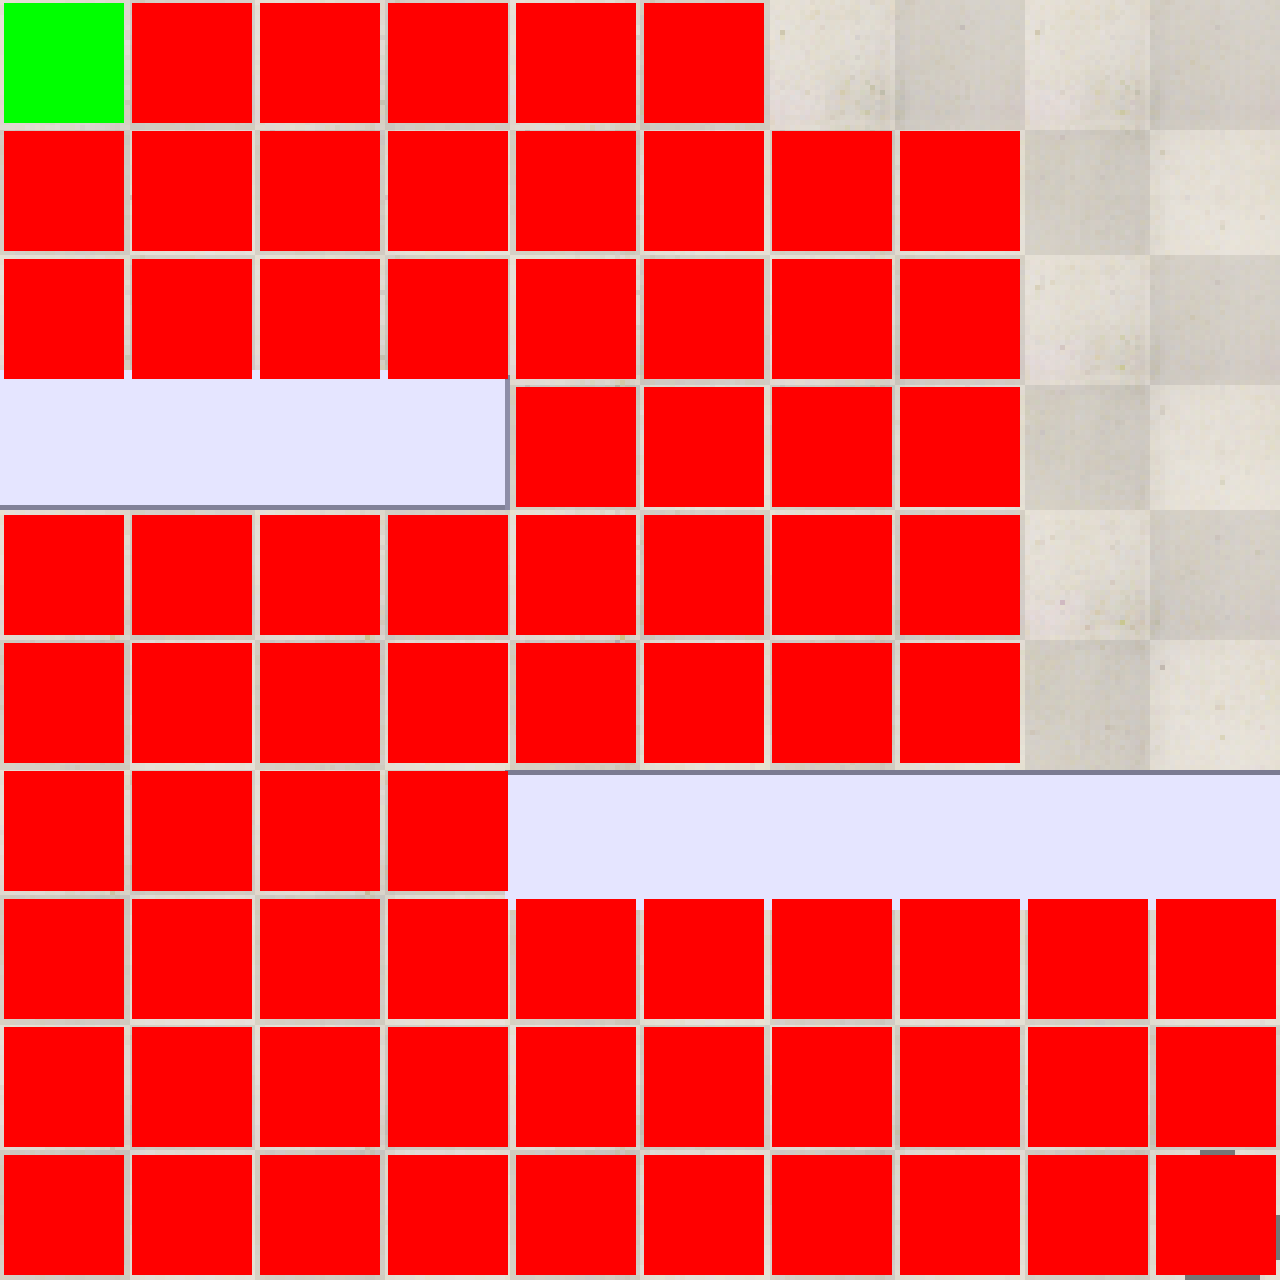

In [5]:
image_pp = Image.fromarray(resized)
image_pp




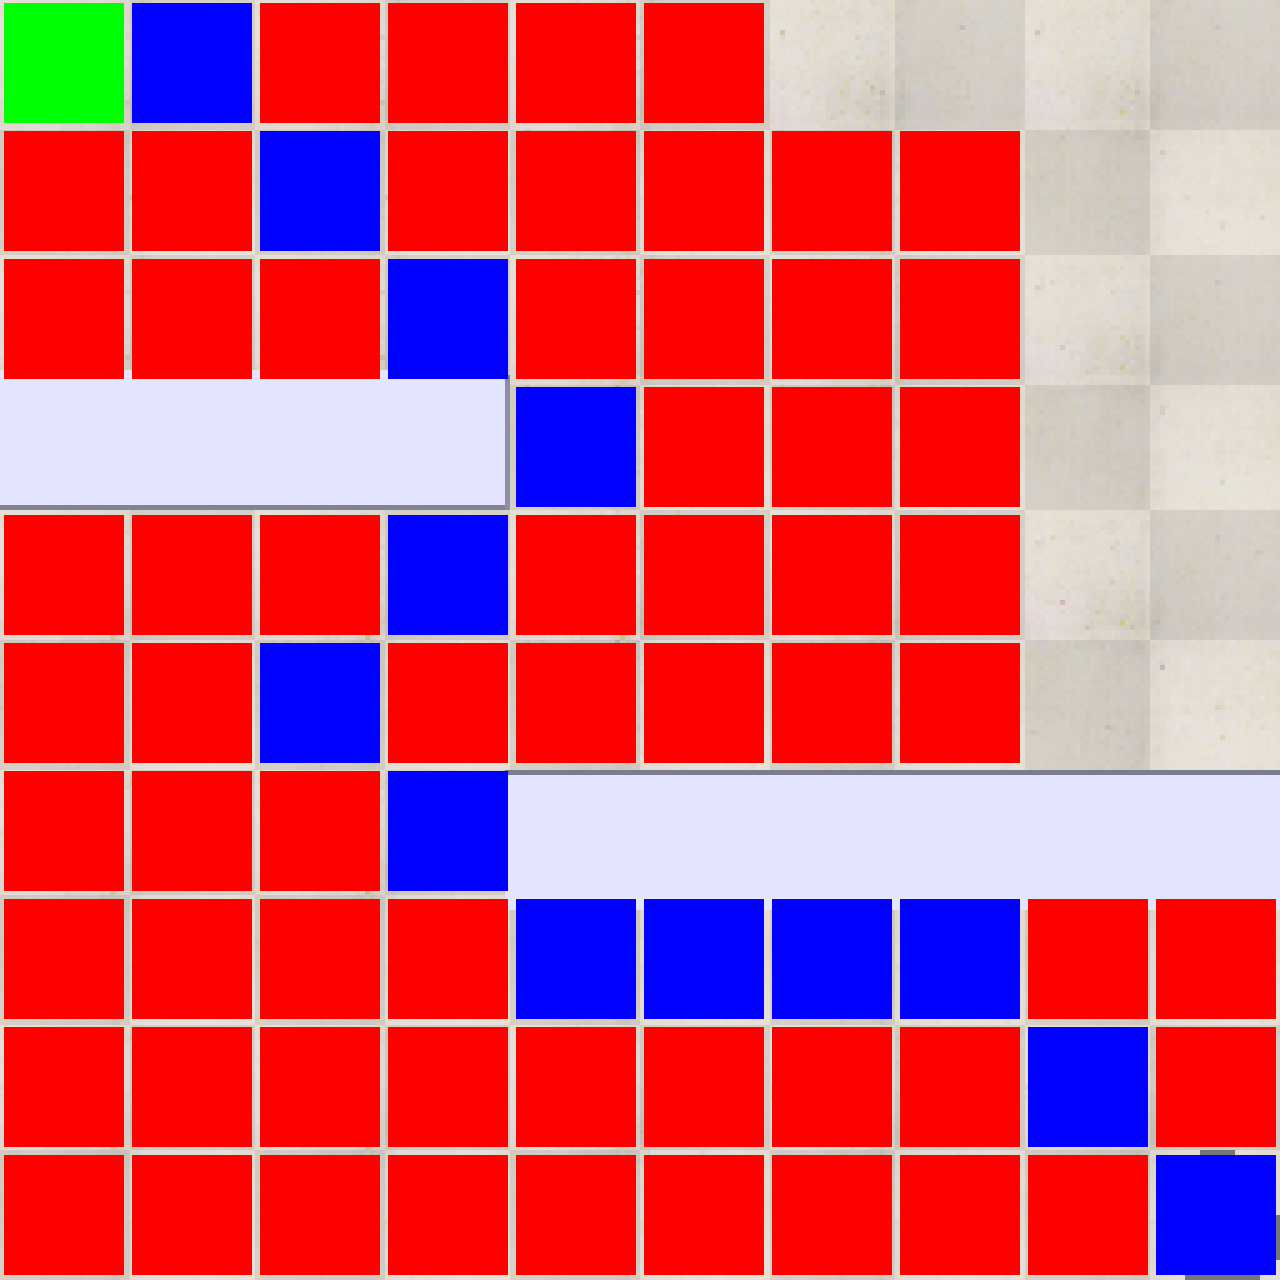

In [6]:
cccc=ccc[1:]
for i in cccc:
    draw_rec_blue(i,resized)
draw_rec_green(ccc[-1],resized)
image_pp = Image.fromarray(resized)
image_pp
